# NN Algorithm for dazzled camera identification

In [75]:
import numpy as np 
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

In [76]:
def Max(data_array):
    max = np.max(data_array, axis=1)
    return max

def Amp(data_array):
    amp = np.sum(data_array, axis=1)
    return amp

def Std(data_array):
    std = np.std(data_array, axis=1)
    return std

def Ratio(data_array):
    max = np.max(data_array, axis=1)
    mean = np.mean(data_array, axis=1)
    ratio = 1 - mean/max
    ratio[np.isnan(ratio)] = 1
    return ratio

## Import data and MC truth

In [77]:
data_path = './dazzled_cameras_dataset'

# Load Data  
with open(data_path+'/simulation_11.npy', 'rb') as b:    #'+str(sim_num)+'
    data_in_1 = np.load(b)
with open(data_path+'/simulation_22.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_2 = np.load(c)
with open(data_path+'/simulation_33.npy', 'rb') as c:    #'+str(sim_num)+'
    data_in_3 = np.load(c)
    
# Load MC Truth
with open(data_path+'/inner_ph_11.npy', 'rb') as f:      #'+str(sim_num)+'
    ph_in_1 = np.load(f)
with open(data_path+'/inner_ph_22.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_2 = np.load(g)
with open(data_path+'/inner_ph_33.npy', 'rb') as g:      #'+str(sim_num)+'
    ph_in_3 = np.load(g) 

## Exploring the Dataset

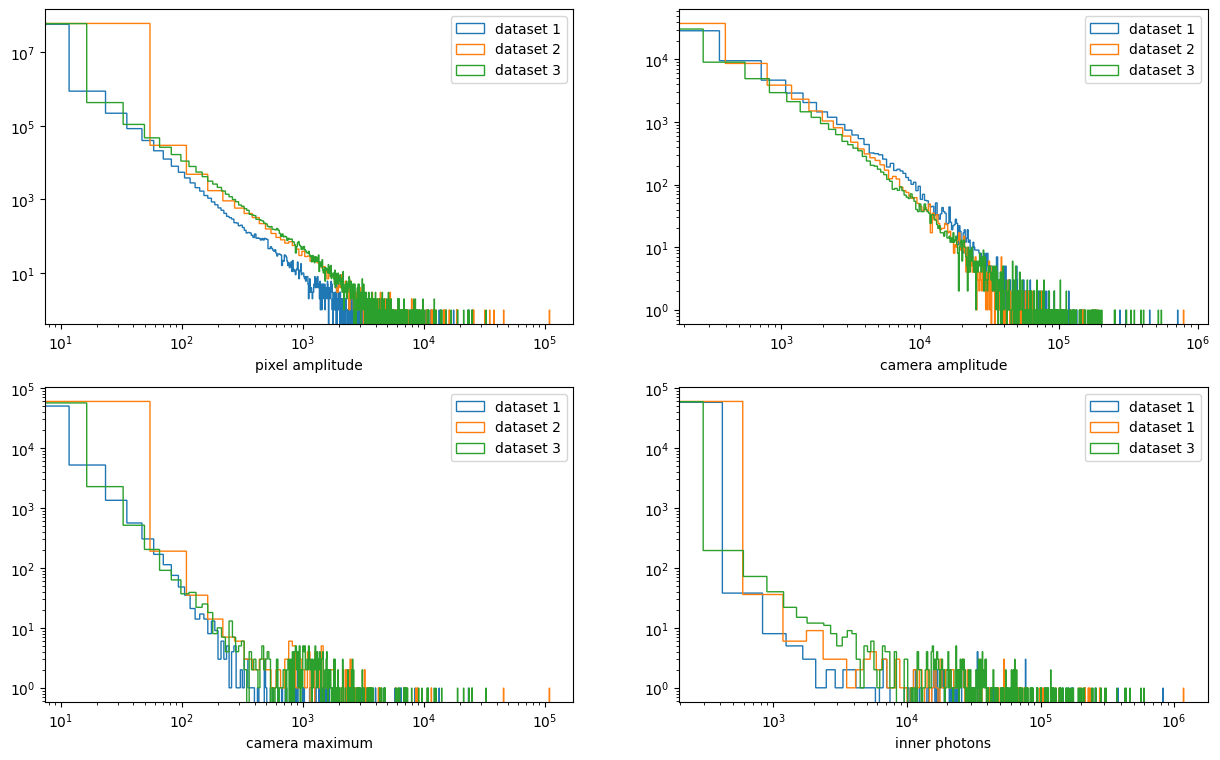

In [78]:
###### fixed parameters ###########
#n_cam_in_grain_0 = 54
n_cam_in_grain_1 = 58
n_cam_in_grain_2 = 60
n_cam_in_grain_3 = 60
cam_side_length = 32
###################################

fig, ax = plt.subplots(2,2)

ax[0,0].hist(data_in_1, 2000, histtype='step', label='dataset 1');
ax[0,0].hist(data_in_2, 2000, histtype='step', label='dataset 2');
ax[0,0].hist(data_in_3, 2000, histtype='step', label='dataset 3');
ax[0,0].set_yscale('log')
ax[0,0].set_xscale('log')
ax[0,0].set_xlabel('pixel amplitude')
ax[0,0].legend()

ax[0,1].hist(np.sum(data_in_1.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 1');
ax[0,1].hist(np.sum(data_in_2.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 2');
ax[0,1].hist(np.sum(data_in_3.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 3');
ax[0,1].set_yscale('log')
ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('camera amplitude')
ax[0,1].legend()

ax[1,0].hist(np.max(data_in_1.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 1');
ax[1,0].hist(np.max(data_in_2.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 2');
ax[1,0].hist(np.max(data_in_3.reshape(-1, cam_side_length**2), axis=1), 2000, histtype='step', label='dataset 3');
ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')
ax[1,0].set_xlabel('camera maximum')
ax[1,0].legend()

ax[1,1].hist(ph_in_1[:,0], 2000, histtype='step', label='dataset 1')
ax[1,1].hist(ph_in_2[:,0], 2000, histtype='step', label='dataset 1')
ax[1,1].hist(ph_in_3[:,0], 2000, histtype='step', label='dataset 3')
ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_xlabel('inner photons')
ax[1,1].legend()

fig.set_figwidth(15)
fig.set_figheight(9)

## Preprocessing

### Concatenate multiple datasets

In [79]:
inner_ph_in_1 = ph_in_1[:,0].reshape(n_cam_in_grain_1, -1)
inner_ph_in_2 = ph_in_2[:,0].reshape(n_cam_in_grain_2, -1)
inner_ph_in_3 = ph_in_3[:,0].reshape(n_cam_in_grain_3, -1)

inner_ratio_11 = ((ph_in_1[:,0])/(ph_in_1[:,1]-(ph_in_1[:,0]))).reshape(n_cam_in_grain_1, -1)
inner_ratio_22 = ((ph_in_2[:,0])/(ph_in_2[:,1]-(ph_in_2[:,0]))).reshape(n_cam_in_grain_2, -1)
inner_ratio_33 = ((ph_in_3[:,0])/(ph_in_3[:,1]-(ph_in_3[:,0]))).reshape(n_cam_in_grain_3, -1)
inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_grain_2, -1)
inner_ratio_3 = (ph_in_3[:,0]/ph_in_3[:,1]).reshape(n_cam_in_grain_3, -1)

data_in = np.concatenate((data_in_1.reshape(-1, cam_side_length**2), data_in_2.reshape(-1, cam_side_length**2), data_in_3.reshape(-1, cam_side_length**2))) #new_data_0, 
inner_ph_in = np.concatenate((np.ravel(inner_ph_in_1, order='F'), np.ravel(inner_ph_in_2, order='F'), np.ravel(inner_ph_in_3, order='F')))
inner_ratio = np.concatenate((np.ravel(inner_ratio_11, order='F'), np.ravel(inner_ratio_22, order='F'), np.ravel(inner_ratio_33, order='F')))

inner_ratio[np.isnan(inner_ratio)] = 0

# INCLUDE PIXEL SATURATION
data_in[data_in > 1000] = 1000


C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\38902620.py:5: RuntimeWarning: invalid value encountered in divide
  inner_ratio_11 = ((ph_in_1[:,0])/(ph_in_1[:,1]-(ph_in_1[:,0]))).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\38902620.py:6: RuntimeWarning: invalid value encountered in divide
  inner_ratio_22 = ((ph_in_2[:,0])/(ph_in_2[:,1]-(ph_in_2[:,0]))).reshape(n_cam_in_grain_2, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\38902620.py:7: RuntimeWarning: invalid value encountered in divide
  inner_ratio_33 = ((ph_in_3[:,0])/(ph_in_3[:,1]-(ph_in_3[:,0]))).reshape(n_cam_in_grain_3, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\38902620.py:8: RuntimeWarning: invalid value encountered in divide
  inner_ratio_1 = (ph_in_1[:,0]/ph_in_1[:,1]).reshape(n_cam_in_grain_1, -1)
C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\38902620.py:9: RuntimeWarning: invalid value encountered in divide
  inner_ratio_2 = (ph_in_2[:,0]/ph_in_2[:,1]).reshape(n_cam_in_gra

### Testing different parameters to label data

### Data labelling

In [80]:
label = np.zeros(inner_ph_in.shape[0])

for i in np.where( inner_ph_in > 0 )[0]:
    label[i] = 1

### Feature Extraction

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


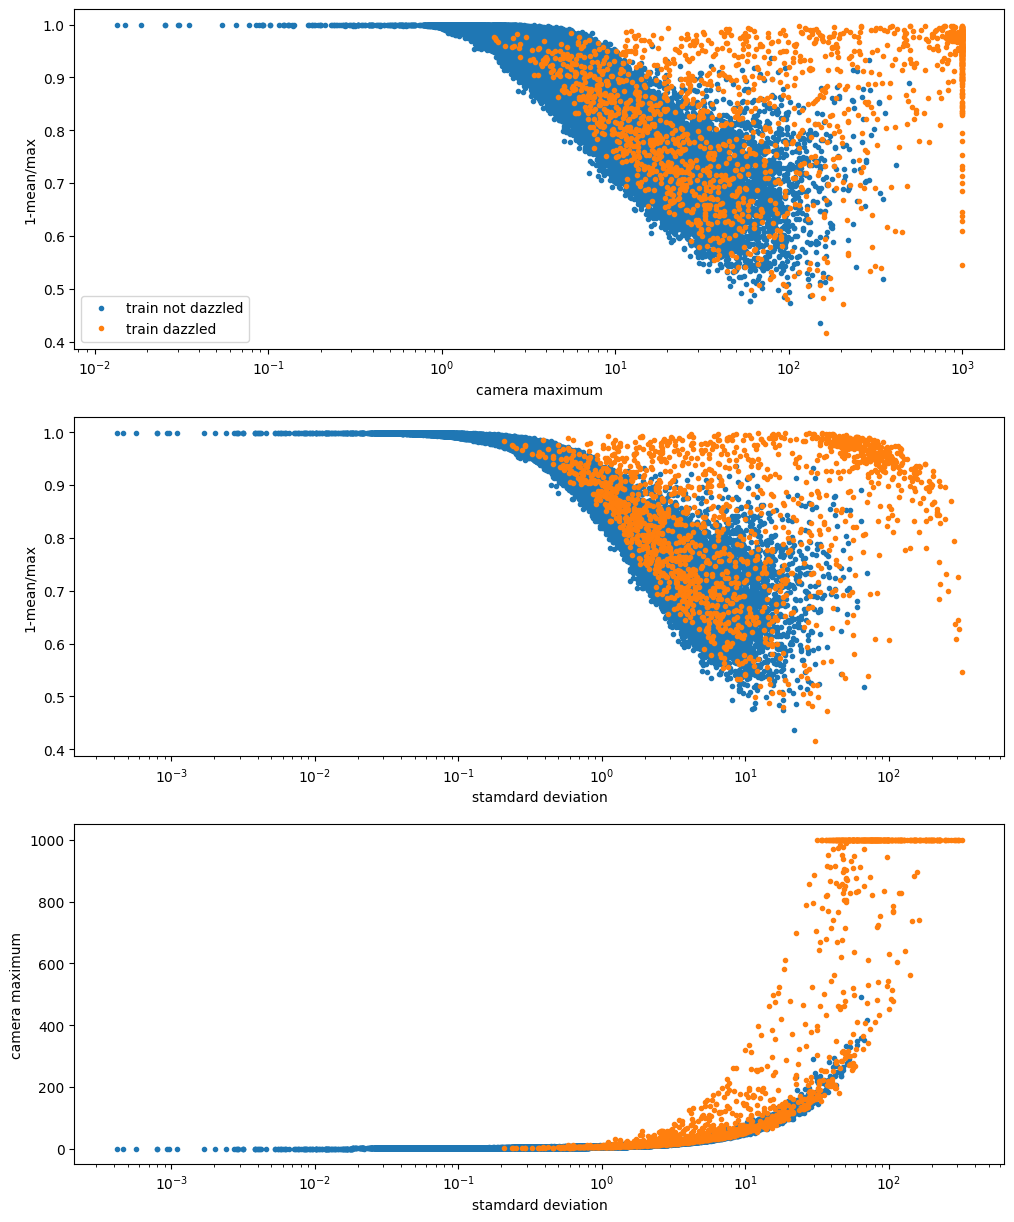

In [81]:
fig, ax = plt.subplots(3,1)

ax[0].plot(Max(data_in)[label == 0], Ratio(data_in)[label == 0], '.', label='train not dazzled')
ax[0].plot(Max(data_in)[label == 1], Ratio(data_in)[label == 1], '.', label='train dazzled')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Std(data_in)[label == 0], Ratio(data_in)[label == 0], '.', label='train not dazzled')
ax[1].plot(Std(data_in)[label == 1], Ratio(data_in)[label == 1], '.', label='train dazzled')
ax[1].set_xscale('log')
ax[1].set_ylabel('1-mean/max')
ax[1].set_xlabel('stamdard deviation')

ax[2].plot(Std(data_in)[label == 0], Max(data_in)[label == 0], '.', label='train not dazzled')
ax[2].plot(Std(data_in)[label == 1], Max(data_in)[label == 1], '.', label='train dazzled')
ax[2].set_xscale('log')
ax[2].set_xlabel('stamdard deviation')
ax[2].set_ylabel('camera maximum')

fig.set_figwidth(12)
fig.set_figheight(15)

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


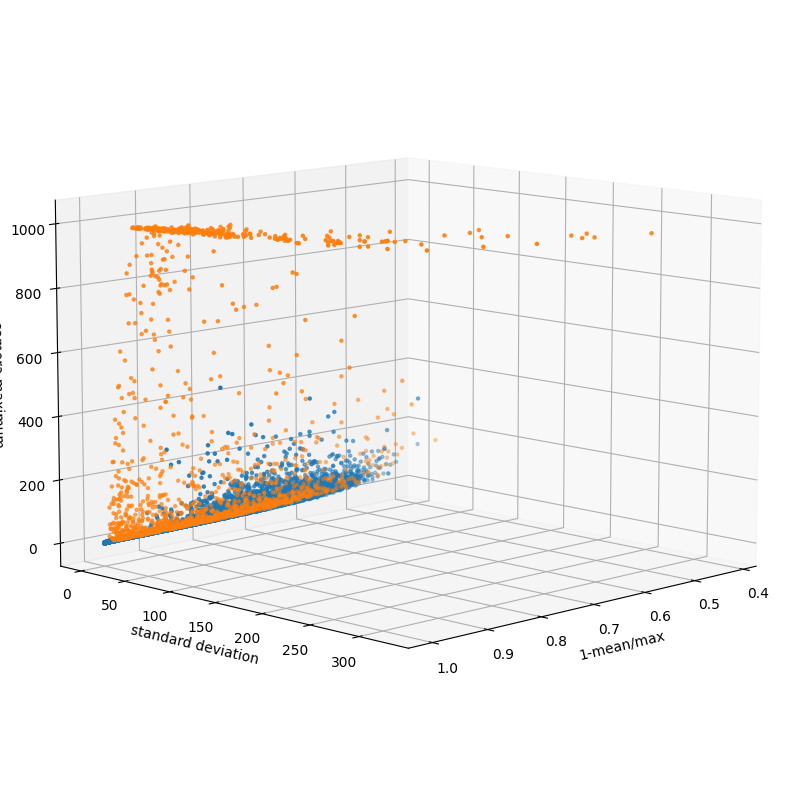

In [82]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Ratio(data_in)[label == 0], Std(data_in)[label == 0], Max(data_in)[label == 0], marker='.')
ax.scatter(Ratio(data_in)[label == 1], Std(data_in)[label == 1], Max(data_in)[label == 1], marker='.')
ax.set_xlabel('1-mean/max')
ax.set_ylabel('standard deviation')
ax.set_zlabel('camera maximum')

fig.set_figheight(10)
fig.set_figwidth(20)

ax.view_init(10, 45) 
plt.show()

This plot displays raw data separated between dazzled and non-dazzled cameras. In the following cells we try to apply some cuts in order to discard dazzled-classified cameras which however have a negligible impact whether misclassified. 

This is done beacuse, according to these features, there is a certain number of dazzled cameras whose features are not distinguishable from those of non-dazzled ones.
Being able to apply some cuts in this region could help the algorithm in the classification.

#### Threshold on the number of inner photons per camera

Text(0.5, 0, 'inner photons')

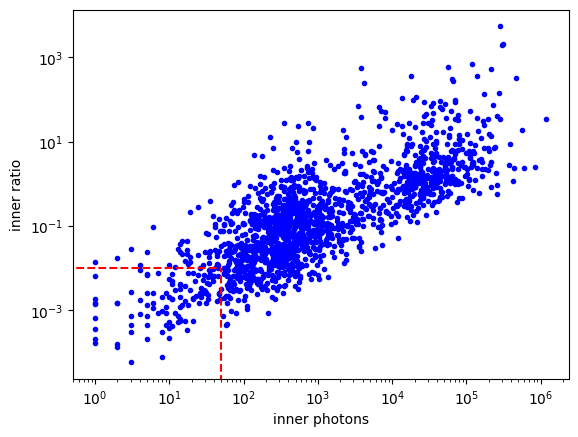

In [83]:
thr = 50
cut = 1/100

plt.plot(inner_ph_in, inner_ratio, 'b.')
plt.plot([0,thr], [cut,cut], 'r--')
plt.plot([thr,thr],[0,cut], 'r--')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('inner ratio')
plt.xlabel('inner photons')

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


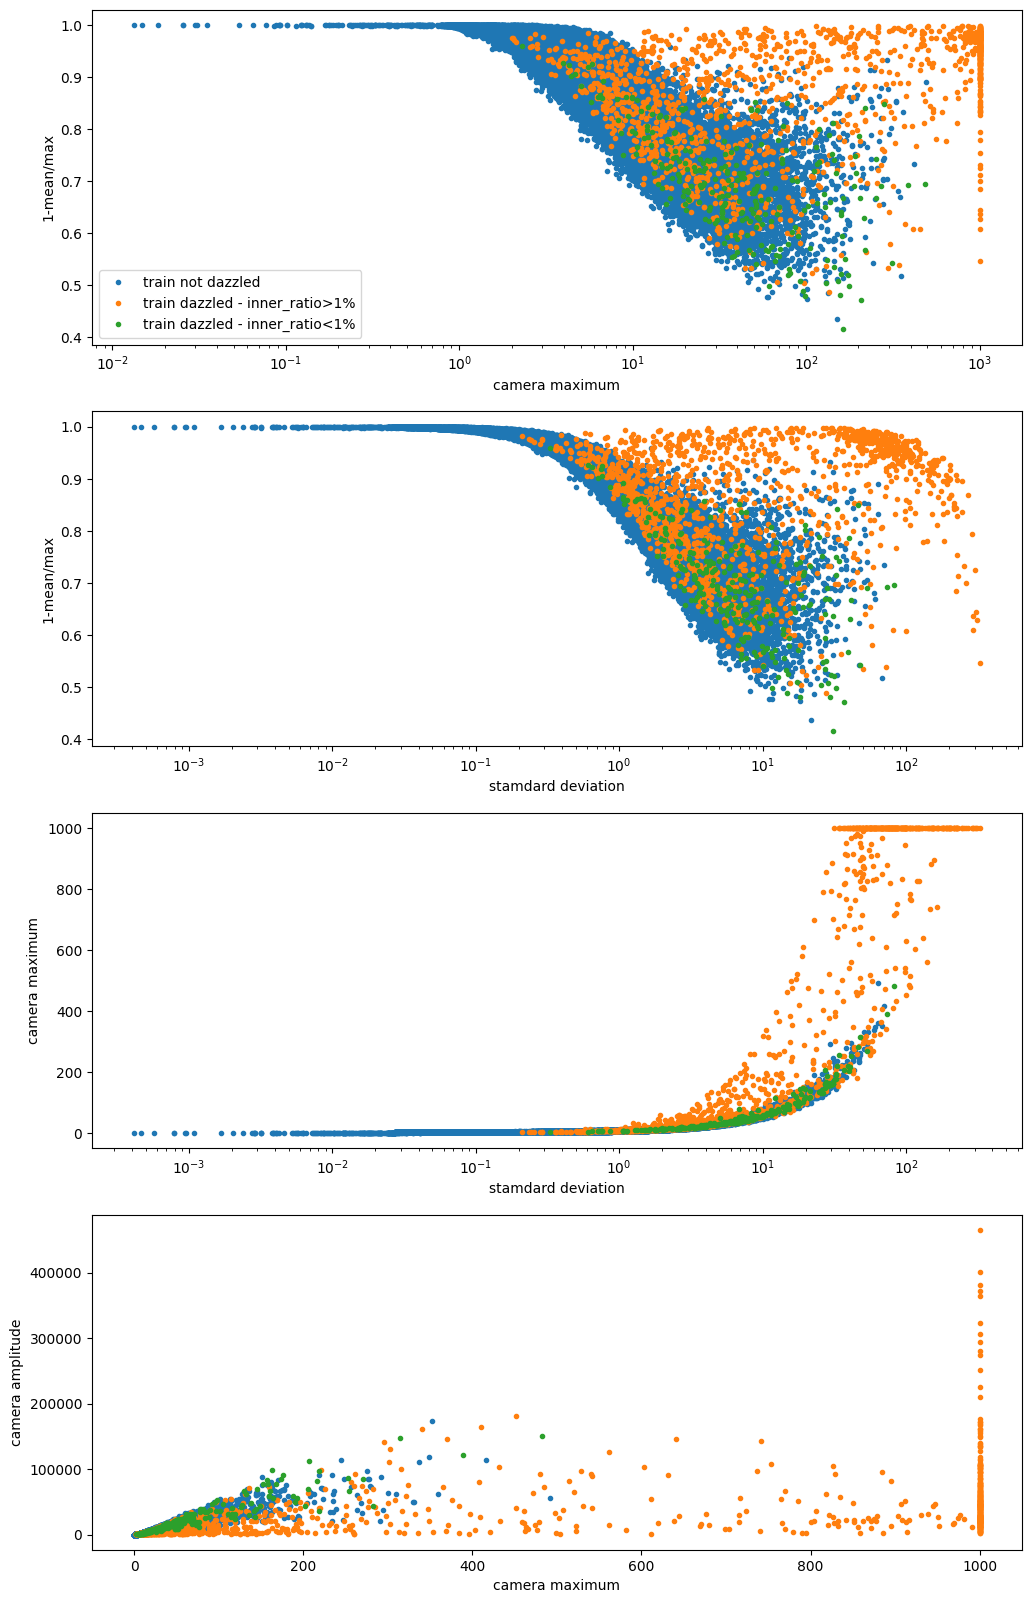

In [84]:
fig, ax = plt.subplots(4,1)

ax[0].plot(Max(data_in)[(label == 0)], Ratio(data_in)[(label == 0)], '.', label='train not dazzled')
ax[0].plot(Max(data_in)[(label == 1) & (inner_ratio>=cut)], Ratio(data_in)[(label == 1) & (inner_ratio>=cut)], '.', label='train dazzled - inner_ratio>1%')
ax[0].plot(Max(data_in)[(label == 1) & (inner_ratio<cut)], Ratio(data_in)[(label == 1) & (inner_ratio<cut)], '.', label='train dazzled - inner_ratio<1%')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Std(data_in)[label == 0], Ratio(data_in)[label == 0], '.', label='train not dazzled')
ax[1].plot(Std(data_in)[(label == 1) & (inner_ratio>=cut)], Ratio(data_in)[(label == 1) & (inner_ratio>=cut)], '.', label='train dazzled - inner_ratio>1%')
ax[1].plot(Std(data_in)[(label == 1) & (inner_ratio<cut)], Ratio(data_in)[(label == 1) & (inner_ratio<cut)], '.', label='train dazzled - inner_ratio<1%')
ax[1].set_xscale('log')
ax[1].set_ylabel('1-mean/max')
ax[1].set_xlabel('stamdard deviation')

ax[2].plot(Std(data_in)[label == 0], Max(data_in)[label == 0], '.', label='train not dazzled')
ax[2].plot(Std(data_in)[(label == 1) & (inner_ratio>=cut)], Max(data_in)[(label == 1) & (inner_ratio>=cut)], '.', label='train dazzled - inner_ratio>1%')
ax[2].plot(Std(data_in)[(label == 1) & (inner_ratio<cut)], Max(data_in)[(label == 1) & (inner_ratio<cut)], '.', label='train dazzled - inner_ratio<1%')
ax[2].set_xscale('log')
ax[2].set_xlabel('stamdard deviation')
ax[2].set_ylabel('camera maximum')

ax[3].plot(Max(data_in)[label == 0], Amp(data_in)[label == 0], '.', label='train not dazzled')
ax[3].plot(Max(data_in)[(label == 1) & (inner_ratio>=cut)], Amp(data_in)[(label == 1) & (inner_ratio>=cut)], '.')
ax[3].plot(Max(data_in)[(label == 1) & (inner_ratio<cut)], Amp(data_in)[(label == 1) & (inner_ratio<cut)], '.')
# plt.xscale('log')
# plt.yscale('log')
ax[3].set_ylabel('camera amplitude')
ax[3].set_xlabel('camera maximum')

fig.set_figwidth(12)
fig.set_figheight(20)

### Data labelling

In [85]:
## PARAMETERS ##
ph_threshold = 50           # SET A MINIMUM THRESHOLD FOR THE NUMBER OF PHOTONS PRODUCED INSIDE A CAMERA
ratio_threshold = 0.01      # SET A LOWER BOUND FOR THE RATIO
###########################################################################################################

label = np.zeros(inner_ph_in.shape[0])

for i in np.where( (inner_ratio > ratio_threshold) & (inner_ph_in > ph_threshold) )[0]:
    label[i] = 1
    
n_dazzled = label[label==1].shape[0]
n_not_dazzled = label[label==0].shape[0]
print('labelled-dazzlecameras :', n_dazzled )
print('labelled-non dazzlecameras :', n_not_dazzled )
print('dazzlecameras abundance :', 100*n_dazzled/n_not_dazzled, '%')

labelled-dazzlecameras : 1393
labelled-non dazzlecameras : 176607
dazzlecameras abundance : 0.7887569575384894 %


### Split into test and training sets

In [86]:
sep = int(data_in.shape[0] * 0.8)

train_data, test_data = data_in[:sep], data_in[sep:]
train_label, test_label = label[:sep], label[sep:]

### Data augmentation for dazzled dataset

In [90]:
train_dazzled = train_data[np.where(train_label==1)]
train_not_dazzled = train_data[np.where(train_label==0)]

rdm = np.random.default_rng(12345)
rdm_x = rdm.integers(low=0, high=31, size=int(0.3*n_not_dazzled))
rdm_y = rdm.integers(low=0, high=31, size=int(0.3*n_not_dazzled))
artificial_train_dazzled = np.repeat(train_dazzled, int(0.3*n_not_dazzled/train_dazzled.shape[0]), axis=0).reshape(-1, cam_side_length, cam_side_length, 1)

for r in range(artificial_train_dazzled.shape[0]) :
    artificial_train_dazzled[r] = np.roll(artificial_train_dazzled[r], (rdm_x[r] ,rdm_y[r]), axis=(2,1))
    
artificial_train_label = np.ones(artificial_train_dazzled.shape[0])

train_data = train_data.reshape(-1, cam_side_length, cam_side_length, 1)
test_data = test_data#.reshape(-1, cam_side_length, cam_side_length, 1)

train_data_aug = np.append(artificial_train_dazzled, train_data, axis=0).astype('float32').reshape(-1, cam_side_length**2)
train_label_aug = np.append(artificial_train_label, train_label).astype('float32')

train_arr = np.column_stack((Ratio(train_data_aug), Max(train_data_aug)))
test_arr = np.column_stack((Ratio(test_data), Max(test_data)))

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


### Plot augmented data

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


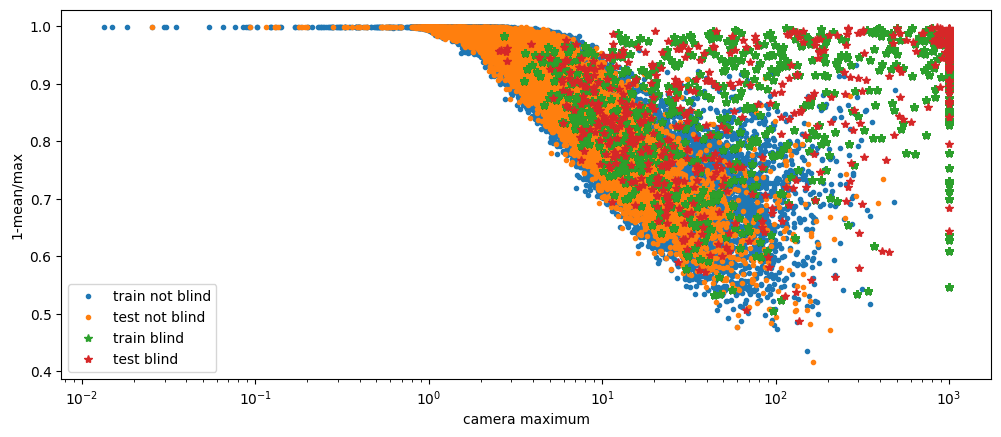

In [92]:
plt.figure().set_figwidth(12)
plt.plot(Max(train_data_aug)[train_label_aug == 0], Ratio(train_data_aug)[train_label_aug == 0], '.', label='train not blind')
plt.plot(Max(test_data)[test_label == 0], Ratio(test_data)[test_label == 0], '.', label='test not blind')
plt.plot(Max(train_data_aug)[train_label_aug == 1], Ratio(train_data_aug)[train_label_aug == 1], '*', label='train blind')
plt.plot(Max(test_data)[test_label == 1], Ratio(test_data)[test_label == 1], '*', label='test blind')

plt.xscale('log')
plt.xlabel('camera maximum')
plt.ylabel('1-mean/max')
plt.legend()

## Build the model

### Model 1 - SGD

In [94]:
sgd_clf = SGDClassifier(max_iter=2000, tol=1e-3, random_state=42)
sgd_clf.fit(train_arr, train_label_aug)

sgd_score = sgd_clf.score(test_arr, test_label)
cross_score = cross_val_score(sgd_clf, test_arr, test_label, cv=2, scoring="precision")
pred_label = cross_val_predict(sgd_clf, test_arr, test_label, cv=2)

cm = confusion_matrix(pred_label, test_label)
prec = precision_score(pred_label, test_label)
reca = recall_score(pred_label, test_label)
f1 = f1_score(pred_label, test_label)
    
print('confusion matrix :')
print(cm)
print('precision :', prec)
print('recall :', reca)
print('f1 score :', f1)

confusion matrix :
[[34988   319]
 [   65   228]]
precision : 0.41681901279707495
recall : 0.7781569965870307
f1 score : 0.5428571428571428


### Model 2 - KFold

In [95]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
LR = LogisticRegression() #LinearRegression()

cross_score_LR = cross_val_score(LR, test_arr, test_label, cv=kfold, scoring='neg_mean_absolute_error')
pred_label_LR = cross_val_predict(LR, test_arr, test_label, cv=kfold)

cm_LR = confusion_matrix(pred_label_LR, test_label)
prec_LR = precision_score(pred_label_LR, test_label)
reca_LR = recall_score(pred_label_LR, test_label)
f1_LR = f1_score(pred_label_LR, test_label)
    
print('kfold :', kfold)
print('confusion matrix :')
print(cm_LR)
print('precision :', prec_LR)
print('recall :', reca_LR)
print('f1 score :', f1_LR)

kfold : KFold(n_splits=10, random_state=7, shuffle=True)
confusion matrix :
[[35017   340]
 [   36   207]]
precision : 0.37842778793418647
recall : 0.8518518518518519
f1 score : 0.5240506329113924


## Prediction vs MC truth visualization

### Model 1

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


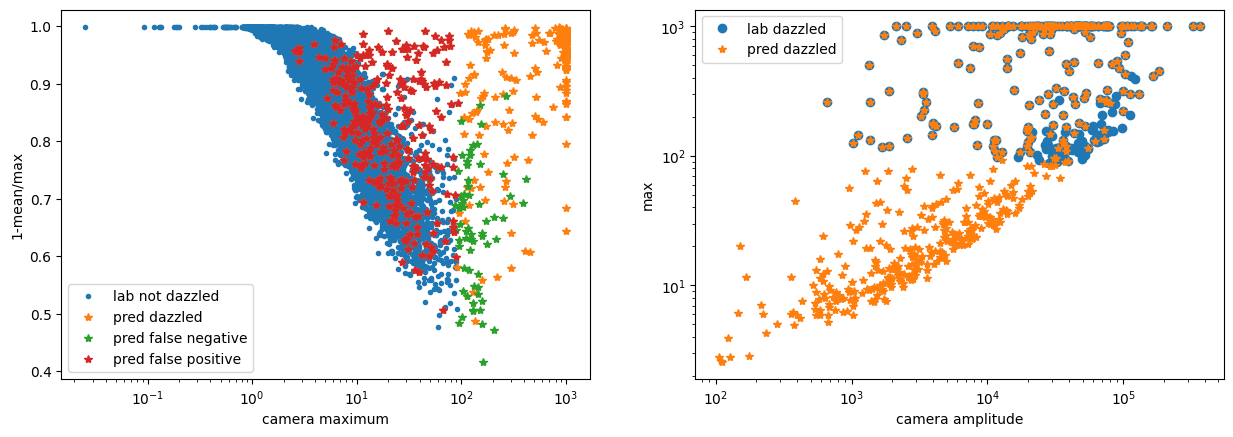

In [96]:
test_d = data_in[sep:]

lab_daz = test_d[np.where(pred_label==1)]
lab_not_daz = test_d[np.where(pred_label==0)]
pred_daz = test_d[np.where(test_label==1)]
pred_not_daz = test_d[np.where(test_label==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_label==1), np.where(test_label==0))]
pred_fp = test_d[np.intersect1d(np.where(pred_label==0), np.where(test_label==1))]

fig, ax = plt.subplots(1,2)
ax[0].plot(Max(lab_not_daz), Ratio(lab_not_daz), '.', label='lab not dazzled')
ax[0].plot(Max(pred_daz), Ratio(pred_daz), '*', label='pred dazzled')
ax[0].plot(Max(pred_fn), Ratio(pred_fn), '*', label='pred false negative')
ax[0].plot(Max(pred_fp), Ratio(pred_fp), '*', label='pred false positive')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Amp(lab_daz), Max(lab_daz), 'o', label='lab dazzled')
ax[1].plot(Amp(pred_daz), Max(pred_daz), '*', label='pred dazzled')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

fig.set_figwidth(15)

### Model 2

C:\Users\Pc\AppData\Local\Temp\ipykernel_25444\2026587943.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = 1 - mean/max


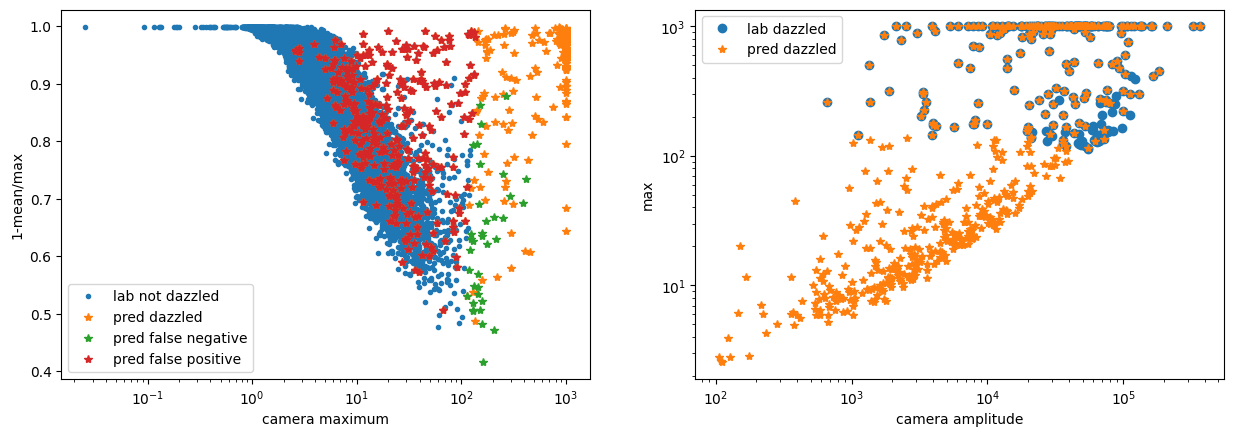

In [97]:
test_d = data_in[sep:]

lab_daz = test_d[np.where(pred_label_LR==1)]
lab_not_daz = test_d[np.where(pred_label_LR==0)]
pred_daz = test_d[np.where(test_label==1)]
pred_not_daz = test_d[np.where(test_label==0)]
pred_fn = test_d[np.intersect1d(np.where(pred_label_LR==1), np.where(test_label==0))]
pred_fp = test_d[np.intersect1d(np.where(pred_label_LR==0), np.where(test_label==1))]

fig, ax = plt.subplots(1,2)
ax[0].plot(Max(lab_not_daz), Ratio(lab_not_daz), '.', label='lab not dazzled')
ax[0].plot(Max(pred_daz), Ratio(pred_daz), '*', label='pred dazzled')
ax[0].plot(Max(pred_fn), Ratio(pred_fn), '*', label='pred false negative')
ax[0].plot(Max(pred_fp), Ratio(pred_fp), '*', label='pred false positive')
ax[0].set_xscale('log')
ax[0].set_xlabel('camera maximum')
ax[0].set_ylabel('1-mean/max')
ax[0].legend()

ax[1].plot(Amp(lab_daz), Max(lab_daz), 'o', label='lab dazzled')
ax[1].plot(Amp(pred_daz), Max(pred_daz), '*', label='pred dazzled')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('camera amplitude')
ax[1].set_ylabel('max')
ax[1].legend()

fig.set_figwidth(15)